In [29]:
%pip install -U numpy pandas seaborn plotly scikit-learn matplotlib kagglehub nbformat

Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

In [32]:
import os
# import kagglehub

# path = kagglehub.dataset_download('kartik2112/fraud-detection') 

data_dir = os.path.join("dataset", "fraud-detection")
train_path = os.path.join(data_dir, "fraudTrain.csv")
test_path  = os.path.join(data_dir, "fraudTest.csv")

In [33]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [34]:
print(train_df.shape, test_df.shape)
# print(train_df.head(3))
# print(test_df.head(3))

(1296675, 23) (555719, 23)


In [35]:
print(train_df.columns)
print(train_df['is_fraud'].value_counts(normalize=True)) 

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')
is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


In [36]:
drop_cols = [
    "Unnamed: 0",
    "cc_num",
    "trans_num",
    "first", "last",
    "street", "city", "state", "zip"
]

train_df = train_df.drop(columns=drop_cols)

print("Kích thước dữ liệu sau khi bỏ cột:", train_df.shape)
print("Các cột còn lại:", train_df.columns.tolist())

Kích thước dữ liệu sau khi bỏ cột: (1296675, 14)
Các cột còn lại: ['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


In [37]:
train_df["trans_date_trans_time"] = pd.to_datetime(train_df["trans_date_trans_time"])
train_df["dob"] = pd.to_datetime(train_df["dob"], errors="coerce")

train_df["age"] = train_df["trans_date_trans_time"].dt.year - train_df["dob"].dt.year

print(train_df[["age"]].head())

   age
0   31
1   41
2   57
3   52
4   33


$$
d = 2R \cdot \arctan2\left(\sqrt{a}, \sqrt{1 - a}\right)
$$

trong đó

$$
a = \sin^2\!\left(\frac{\Delta \varphi}{2}\right)
   + \cos(\varphi_1) \cdot \cos(\varphi_2) \cdot \sin^2\!\left(\frac{\Delta \lambda}{2}\right)
$$

* $\varphi_1, \varphi_2$: vĩ độ của 2 điểm (tính bằng radian)
* $\lambda_1, \lambda_2$: kinh độ của 2 điểm (tính bằng radian)
* $\Delta \varphi = \varphi_2 - \varphi_1$
* $\Delta \lambda = \lambda_2 - \lambda_1$
* $R$: bán kính Trái Đất (\~6371 km)
* $d$: khoảng cách theo cung tròn lớn nhất (great-circle distance)


In [38]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [39]:
train_df["distance_km"] = train_df.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
    axis=1
)

In [40]:
print(train_df[["distance_km"]].head())

   distance_km
0    78.597568
1    30.212176
2   108.206083
3    95.673231
4    77.556744


In [41]:
train_df["gender"] = train_df["gender"].map({"M": 0, "F": 1})

In [42]:
print(train_df["category"].value_counts())
print(train_df["merchant"].value_counts())
print(train_df["job"].value_counts())

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64
merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64
job
Film/video editor             9779
Exhibition designer           919

In [43]:
category_ohe = pd.get_dummies(train_df["category"], prefix="cat")
train_df = pd.concat([train_df, category_ohe], axis=1)
train_df.drop(columns=["category"], inplace=True)

merchant_freq = train_df["merchant"].value_counts().to_dict()
train_df["merchant_freq"] = train_df["merchant"].map(merchant_freq)
train_df.drop(columns=["merchant"], inplace=True)

job_freq = train_df["job"].value_counts().to_dict()
train_df["job_freq"] = train_df["job"].map(job_freq)
train_df.drop(columns=["job"], inplace=True)

In [44]:
print(train_df.head())

  trans_date_trans_time     amt  gender      lat      long  city_pop  \
0   2019-01-01 00:00:18    4.97       1  36.0788  -81.1781      3495   
1   2019-01-01 00:00:44  107.23       1  48.8878 -118.2105       149   
2   2019-01-01 00:00:51  220.11       0  42.1808 -112.2620      4154   
3   2019-01-01 00:01:16   45.00       0  46.2306 -112.1138      1939   
4   2019-01-01 00:03:06   41.96       0  38.4207  -79.4629        99   

         dob   unix_time  merch_lat  merch_long  ...  cat_home  cat_kids_pets  \
0 1988-03-09  1325376018  36.011293  -82.048315  ...     False          False   
1 1978-06-21  1325376044  49.159047 -118.186462  ...     False          False   
2 1962-01-19  1325376051  43.150704 -112.154481  ...     False          False   
3 1967-01-12  1325376076  47.034331 -112.561071  ...     False          False   
4 1986-03-28  1325376186  38.674999  -78.632459  ...     False          False   

   cat_misc_net  cat_misc_pos  cat_personal_care  cat_shopping_net  \
0         

In [48]:
labels=["Genuine","Fraud"]

fraud_or_not = train_df["is_fraud"].value_counts().tolist()

fig = px.pie(values=train_df['is_fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
# fig.show()
fig.show(renderer="browser")
# fig.show(renderer="vscode")

C:\Users\Hoang\AppData\Local\Temp\ipykernel_13468\4065837233.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Hoang\AppData\Local\Temp\ipykernel_13468\4065837233.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



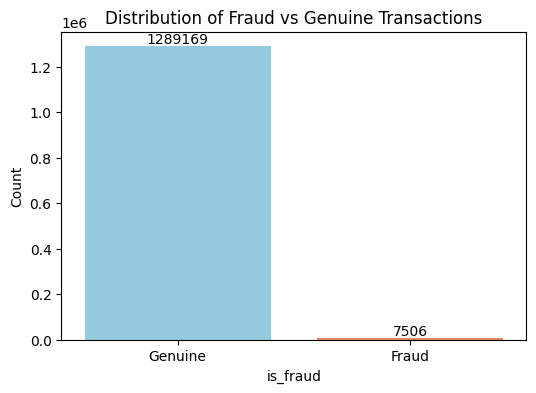

In [52]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='is_fraud', data=train_df, palette=["skyblue", "coral"])
ax.set_xticklabels(['Genuine', 'Fraud'])
ax.set_title('Distribution of Fraud vs Genuine Transactions')
ax.set_ylabel('Count')
for i in ax.containers:
    ax.bar_label(i, fmt='%d')
plt.show()

Thống kê amt:
count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64


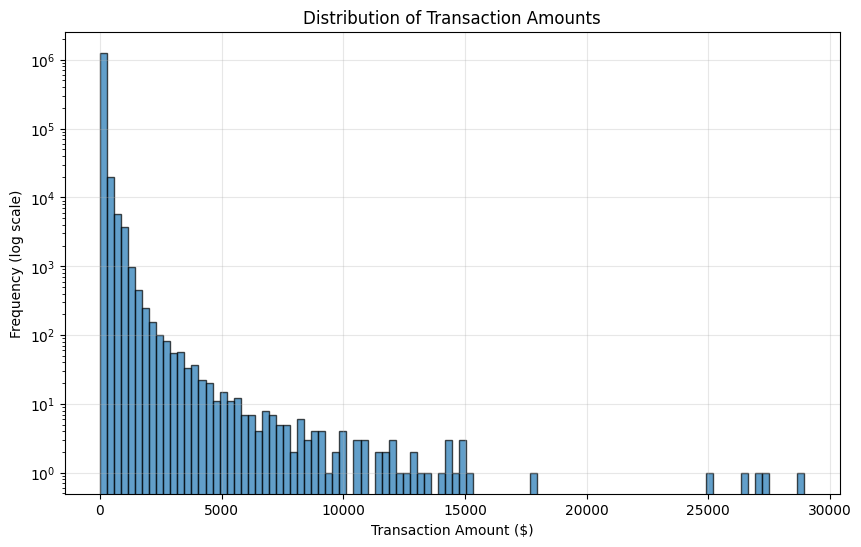

In [56]:
print("Thống kê amt:")
print(train_df['amt'].describe())

plt.figure(figsize=(10, 6))
train_df['amt'].hist(bins=100, alpha=0.7, edgecolor='black')
plt.yscale('log')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Transaction Amounts')
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
train_df['dayofweek'] = train_df['trans_date_trans_time'].dt.dayofweek
pd.crosstab(train_df['hour'], train_df['is_fraud'], normalize='index')

is_fraud,0,1
hour,,
0,0.985060,0.014940
1,0.984651,0.015349
2,0.985348,0.014652
3,0.985761,0.014239
4,0.998901,0.001099
5,0.998577,0.001423
6,0.999054,0.000946
7,0.998673,0.001327
8,0.998847,0.001153


In [58]:
cols_to_drop = [
    'dob',
    'trans_date_trans_time'
]

train_df = train_df.drop(columns=cols_to_drop, errors='ignore')

In [59]:
train_df = train_df.drop(columns='unix_time', errors='ignore')

In [60]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['amt', 'age', 'city_pop',
                    'lat', 'long', 'merch_lat', 'merch_long', 'distance_km']

scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

In [64]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   amt                 555719 non-null  float64
 1   gender              555719 non-null  int64  
 2   lat                 555719 non-null  float64
 3   long                555719 non-null  float64
 4   city_pop            555719 non-null  float64
 5   merch_lat           555719 non-null  float64
 6   merch_long          555719 non-null  float64
 7   is_fraud            555719 non-null  int64  
 8   age                 555719 non-null  float64
 9   distance_km         555719 non-null  float64
 10  cat_entertainment   555719 non-null  bool   
 11  cat_food_dining     555719 non-null  bool   
 12  cat_gas_transport   555719 non-null  bool   
 13  cat_grocery_net     555719 non-null  bool   
 14  cat_grocery_pos     555719 non-null  bool   
 15  cat_health_fitness  555719 non-nul

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 28 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   amt                 1296675 non-null  float64
 1   gender              1296675 non-null  int64  
 2   lat                 1296675 non-null  float64
 3   long                1296675 non-null  float64
 4   city_pop            1296675 non-null  float64
 5   merch_lat           1296675 non-null  float64
 6   merch_long          1296675 non-null  float64
 7   is_fraud            1296675 non-null  int64  
 8   age                 1296675 non-null  float64
 9   distance_km         1296675 non-null  float64
 10  cat_entertainment   1296675 non-null  bool   
 11  cat_food_dining     1296675 non-null  bool   
 12  cat_gas_transport   1296675 non-null  bool   
 13  cat_grocery_net     1296675 non-null  bool   
 14  cat_grocery_pos     1296675 non-null  bool   
 15  cat_health_fitn

In [63]:
test_df = test_df.drop(columns=drop_cols, errors='ignore')
test_df["trans_date_trans_time"] = pd.to_datetime(test_df["trans_date_trans_time"])
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour
test_df['dayofweek'] = test_df['trans_date_trans_time'].dt.dayofweek

test_df["dob"] = pd.to_datetime(test_df["dob"], errors="coerce")
test_df["age"] = test_df["trans_date_trans_time"].dt.year - test_df["dob"].dt.year
test_df["distance_km"] = test_df.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
    axis=1
)
test_df["gender"] = test_df["gender"].map({"M": 0, "F": 1})
test_df["merchant_freq"] = test_df["merchant"].map(merchant_freq).fillna(0)
test_df["job_freq"] = test_df["job"].map(job_freq).fillna(0)

category_ohe_test = pd.get_dummies(test_df["category"], prefix="cat")
test_df = pd.concat([test_df, category_ohe_test], axis=1)

train_cols = train_df.columns.tolist()
test_cols = test_df.columns.tolist()

test_df = test_df[train_cols]

test_df = test_df.drop(columns=cols_to_drop, errors='ignore')
test_df = test_df.drop(columns='unix_time', errors='ignore')

test_df[numeric_features] = scaler.transform(test_df[numeric_features])

print("Remaining columns in test_df:", test_df.columns.tolist())
print("Shape of test_df after feature engineering and scaling:", test_df.shape)

Remaining columns in test_df: ['amt', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_fraud', 'age', 'distance_km', 'cat_entertainment', 'cat_food_dining', 'cat_gas_transport', 'cat_grocery_net', 'cat_grocery_pos', 'cat_health_fitness', 'cat_home', 'cat_kids_pets', 'cat_misc_net', 'cat_misc_pos', 'cat_personal_care', 'cat_shopping_net', 'cat_shopping_pos', 'cat_travel', 'merchant_freq', 'job_freq', 'hour', 'dayofweek']
Shape of test_df after feature engineering and scaling: (555719, 28)


In [65]:
%pip install imbalanced-learn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [67]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier

SMOTETomek_pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
                              RandomForestClassifier(n_estimators=100, random_state=13))

In [68]:
X_train, y_train =train_df.drop('is_fraud', axis=1), train_df['is_fraud']
X_test, y_test = test_df.drop('is_fraud', axis=1), test_df['is_fraud']

In [69]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=3, shuffle=False)

In [70]:
from sklearn.model_selection import cross_val_score

cross_val_score(SMOTETomek_pipeline, X_train, y_train, scoring='recall', cv=kf)

array([0.76418865, 0.80935252, 0.80175859])

In [71]:
SMOTETomek_pipeline.fit(X_train, y_train)
y_pred = SMOTETomek_pipeline.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.80      0.75      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.90      0.87    555719
weighted avg       1.00      1.00      1.00    555719

[[552836    738]
 [   431   1714]]


In [78]:

with open("report.txt", "w") as f:
    f.write(f"\nClassification Report:\n {classification_report(y_test, y_pred)}")
    f.write(f"\n\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

In [79]:
SMOTETomek_pipeline.fit(X_train, y_train)
y_pred = SMOTETomek_pipeline.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Đánh giá trên training set
y_train_pred = SMOTETomek_pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred, output_dict=True)

# Đánh giá trên test set  
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred, output_dict=True)

print("=== OVERFITTING ANALYSIS ===")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")
print(f"Accuracy Gap:   {train_accuracy - test_accuracy:.4f}")

print(f"\nTrain Recall (Fraud): {train_report['1']['recall']:.4f}")
print(f"Test Recall (Fraud):  {test_report['1']['recall']:.4f}")
print(f"Recall Gap:           {train_report['1']['recall'] - test_report['1']['recall']:.4f}")

# Phán đoán overfitting
if train_accuracy - test_accuracy > 0.05:
    print("\n⚠️ OVERFITTING DETECTED!")
    print("→ Train performance >> Test performance")
elif train_accuracy - test_accuracy > 0.02:
    print("\n⚡ Mild overfitting")
else:
    print("\n✅ Good generalization - No overfitting")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

=== OVERFITTING ANALYSIS ===
Train Accuracy: 1.0000
Test Accuracy:  0.9979
Accuracy Gap:   0.0021

Train Recall (Fraud): 1.0000
Test Recall (Fraud):  0.7930
Recall Gap:           0.2070

✅ Good generalization - No overfitting
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.70      0.79      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.85      0.90      0.87    555719
weighted avg       1.00      1.00      1.00    555719

[[552843    731]
 [   444   1701]]
